In [51]:
%run notebook_utils.py

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib

# set big font in plots
SMALL_SIZE = 20
matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=SMALL_SIZE)

In [11]:
%cd ..
from langid import WrappedVectorizer, np_sanitize, sanitize
%cd -

/Users/Lin/git/SwigSpot/language-detection
/Users/Lin/git/SwigSpot/language-detection/notebooks


In [32]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.optimizers import SGD
import numpy
# fix random seed for reproducibility
numpy.random.seed(7)

# Features

In [12]:
X_train, X_test, y_train, y_test = load_split_data()
sms_any_X, sms_any_y = load_sms_any()
X_valid, y_valid = load_validation_data()

# Neural Net -- First attempt

In this first attempt, we use features from Swiss German only and limit the feature vector to 1000 trigrams. 

The model has only one hidden layerThe number of iterations is 50.

In [53]:
ngram_range = (3,3)
num_features = 1000

# create the vectorizer
vectorizer = WrappedVectorizer(analyzer='char', ngram_range=ngram_range, sg_only=True,
                             max_features=num_features, sublinear_tf=True, use_idf=True, norm='l2')

# create the features for training
X = vectorizer.fit_transform(X_train, y_train)

In [34]:
# create model

hidden_size = 500
output_size = len(langs)

model = Sequential()
# using sigmoid vs relu, get got:
#   loss=1.5869, accuracy: 59.4286% and 10660 errors on SMS... => relu is better
model.add(Dense(hidden_size, input_dim=num_features, activation='relu')) # hidden layer: same #neurons as input layer
model.add(Dense(output_size, activation='sigmoid')) # output layer: one for each language
model.add(Activation("softmax")) # add probabilities to the class output

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 2505      
_________________________________________________________________
activation_5 (Activation)    (None, 5)                 0         
Total params: 503,005
Trainable params: 503,005
Non-trainable params: 0
_________________________________________________________________


In [35]:
# train the model using SGD
print("[INFO] compiling model...")
sgd = SGD(lr=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])
model.fit(X, y_train, epochs=50, batch_size=128, verbose=1)

[INFO] compiling model...
Epoch 1/50
29551/29551 [==============================] - 1s 43us/step - loss: 1.6097 - acc: 0.1806
Epoch 2/50
29551/29551 [==============================] - 1s 38us/step - loss: 1.6074 - acc: 0.2822
Epoch 3/50
29551/29551 [==============================] - 1s 37us/step - loss: 1.6051 - acc: 0.3922
Epoch 4/50
29551/29551 [==============================] - 1s 36us/step - loss: 1.6028 - acc: 0.5001
Epoch 5/50
29551/29551 [==============================] - 1s 36us/step - loss: 1.6004 - acc: 0.5884
Epoch 6/50
29551/29551 [==============================] - 1s 36us/step - loss: 1.5980 - acc: 0.6569
Epoch 7/50
29551/29551 [==============================] - 1s 36us/step - loss: 1.5954 - acc: 0.7019
Epoch 8/50
29551/29551 [==============================] - 1s 35us/step - loss: 1.5927 - acc: 0.7393
Epoch 9/50
29551/29551 [==============================] - 1s 36us/step - loss: 1.5899 - acc: 0.7669
Epoch 10/50
29551/29551 [==============================] - 1s 36us/step - 

[INFO] evaluating on testing set...
7388/7388 [==============================] - 0s 19us/step
[INFO] loss=1.2798, accuracy: 96.2101%


Testing recall on SMS:

total samples    10706
total errors       309 (2.89%)
---------------------------------
languages detected
    de      262
    fr        7
    en       20
    it       20
    sg    10397


Validate using the leipzig validation set:

             precision    recall  f1-score   support

         de     0.9152    0.9457    0.9302      2613
         fr     0.9840    0.9675    0.9757      2613
         en     0.9881    0.9545    0.9710      2613
         it     0.9873    0.9832    0.9852      2613
         sg     0.8955    0.9150    0.9052      2613

avg / total     0.9540    0.9532    0.9535     13065



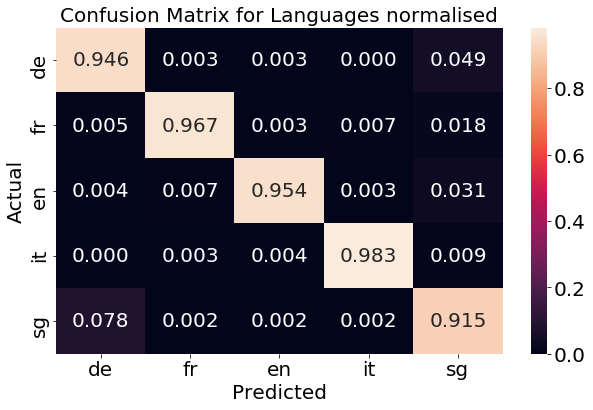

In [57]:
# show the accuracy on the testing set
print("[INFO] evaluating on testing set...")
(loss, accuracy) = model.evaluate(vectorizer.transform(X_test), y_test, batch_size=128, verbose=1)
print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss, accuracy * 100))

print("\n\nTesting recall on SMS:\n")
sms_predicted = model.predict(vectorizer.transform(sms_sg)).argmax(axis=1)
eval_recall_sms(sms_predicted)

print("\n\nValidate using the leipzig validation set:\n")
valid_predicted = model.predict(vectorizer.transform(X_valid)).argmax(axis=1)
print_results(y_valid, valid_predicted)
plot_confusion_matrix(y_valid, valid_predicted, normalised=True)

# Another attempt

In [78]:
ngram_range2 = (3,3)
num_features2 = 6000

# create the vectorizer
vectorizer2 = WrappedVectorizer(analyzer='char', ngram_range=ngram_range2, sg_only=False,
                             max_features=num_features2, sublinear_tf=True, use_idf=True, norm='l2')

# create the features for training
X2 = vectorizer2.fit_transform(X_train, y_train)

In [91]:
# create model

hidden_size2_1 = 2000
hidden_size2_2 = 50
output_size2 = len(langs)

model2 = Sequential()
# using sigmoid vs relu, get got:
#   loss=1.5869, accuracy: 59.4286% and 10660 errors on SMS... => relu is better
model2.add(Dense(hidden_size2_1, input_dim=num_features2, activation='relu')) 
model2.add(Dense(hidden_size2_2, input_dim=hidden_size2_1, activation='relu')) 
model2.add(Dense(output_size2, activation='sigmoid')) 
model2.add(Activation("softmax")) # add probabilities to the class output

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 2000)              12002000  
_________________________________________________________________
dense_38 (Dense)             (None, 50)                100050    
_________________________________________________________________
dense_39 (Dense)             (None, 5)                 255       
_________________________________________________________________
activation_15 (Activation)   (None, 5)                 0         
Total params: 12,102,305
Trainable params: 12,102,305
Non-trainable params: 0
_________________________________________________________________


In [92]:
# train the model using SGD
print("[INFO] compiling model...")
model2.compile(loss="sparse_categorical_crossentropy", optimizer=SGD(lr=0.01), metrics=["accuracy"])
model2.fit(X2, y_train, epochs=10, batch_size=128, verbose=1)

[INFO] compiling model...
Epoch 1/10
29551/29551 [==============================] - 22s 747us/step - loss: 1.6092 - acc: 0.2263
Epoch 2/10
29551/29551 [==============================] - 21s 724us/step - loss: 1.6084 - acc: 0.3140
Epoch 3/10
29551/29551 [==============================] - 22s 749us/step - loss: 1.6075 - acc: 0.3777
Epoch 4/10
29551/29551 [==============================] - 22s 745us/step - loss: 1.6065 - acc: 0.4146
Epoch 5/10
29551/29551 [==============================] - 22s 753us/step - loss: 1.6052 - acc: 0.4912
Epoch 6/10
29551/29551 [==============================] - 22s 742us/step - loss: 1.6038 - acc: 0.5781
Epoch 7/10
29551/29551 [==============================] - 22s 741us/step - loss: 1.6023 - acc: 0.7137
Epoch 8/10
29551/29551 [==============================] - 22s 741us/step - loss: 1.6006 - acc: 0.7651
Epoch 9/10
29551/29551 [==============================] - 22s 740us/step - loss: 1.5988 - acc: 0.8303
Epoch 10/10
29551/29551 [==============================]

[INFO] evaluating on testing set...
7388/7388 [==============================] - 2s 218us/step
[INFO] loss=1.5958, accuracy: 87.5880%


Testing recall on SMS:

total samples    10706
total errors       654 (6.11%)
---------------------------------
languages detected
    de      222
    fr       63
    en      324
    it       45
    sg    10052


Validate using the leipzig validation set:

             precision    recall  f1-score   support

         de     0.9183    0.6322    0.7489      2613
         fr     0.9608    0.9380    0.9493      2613
         en     0.9125    0.9579    0.9347      2613
         it     0.9817    0.9464    0.9638      2613
         sg     0.6777    0.8955    0.7715      2613

avg / total     0.8902    0.8740    0.8736     13065



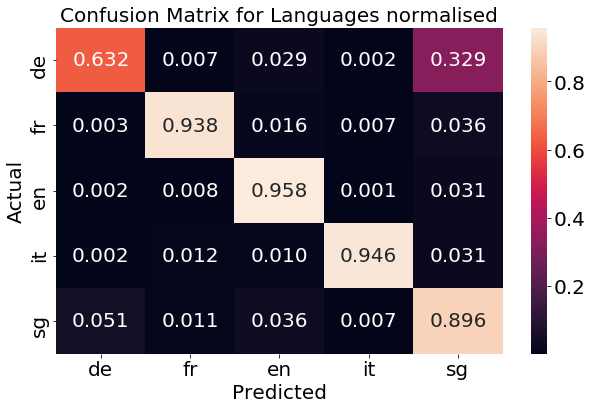

In [93]:
# show the accuracy on the testing set
print("[INFO] evaluating on testing set...")
(loss, accuracy) = model2.evaluate(vectorizer2.transform(X_test), y_test, batch_size=128, verbose=1)
print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss, accuracy * 100))

print("\n\nTesting recall on SMS:\n")
sms_predicted = model2.predict(vectorizer2.transform(sms_sg)).argmax(axis=1)
eval_recall_sms(sms_predicted)

print("\n\nValidate using the leipzig validation set:\n")
valid_predicted = model2.predict(vectorizer2.transform(X_valid)).argmax(axis=1)
print_results(y_valid, valid_predicted)
plot_confusion_matrix(y_valid, valid_predicted, normalised=True)

# Yet another attempt

In [70]:
ngram_range3 = (3,3)
num_features3 = 3000

# create the vectorizer
vectorizer3 = WrappedVectorizer(analyzer='char', ngram_range=ngram_range3, sg_only=False,
                             max_features=num_features3, sublinear_tf=True, use_idf=True, norm='l2')

# create the features for training
X3 = vectorizer3.fit_transform(X_train, y_train)

In [86]:
# create model

hidden_size3_1 = 3000
#hidden_size3_2 = 50
output_size3 = len(langs)

model3 = Sequential()
# using sigmoid vs relu, get got:
#   loss=1.5869, accuracy: 59.4286% and 10660 errors on SMS... => relu is better
model3.add(Dense(hidden_size3_1, input_dim=num_features3, activation='relu')) 
#model3.add(Dense(hidden_size3_2, input_dim=hidden_size3_1, activation='relu')) 
model3.add(Dense(output_size3, activation='sigmoid')) 
model3.add(Activation("softmax")) # add probabilities to the class output

model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 3000)              9003000   
_________________________________________________________________
dense_33 (Dense)             (None, 5)                 15005     
_________________________________________________________________
activation_13 (Activation)   (None, 5)                 0         
Total params: 9,018,005
Trainable params: 9,018,005
Non-trainable params: 0
_________________________________________________________________


In [87]:
# train the model using SGD
print("[INFO] compiling model...")
model3.compile(loss="sparse_categorical_crossentropy", optimizer=SGD(lr=0.01), metrics=["accuracy"])
model3.fit(X3, y_train, epochs=50, batch_size=128, verbose=1)

[INFO] compiling model...
Epoch 1/50
29551/29551 [==============================] - 17s 569us/step - loss: 1.6092 - acc: 0.2224
Epoch 2/50
29551/29551 [==============================] - 16s 552us/step - loss: 1.6078 - acc: 0.3283
Epoch 3/50
29551/29551 [==============================] - 17s 591us/step - loss: 1.6064 - acc: 0.4319
Epoch 4/50
29551/29551 [==============================] - 17s 574us/step - loss: 1.6050 - acc: 0.5536
Epoch 5/50
29551/29551 [==============================] - 19s 640us/step - loss: 1.6035 - acc: 0.6480
Epoch 6/50
29551/29551 [==============================] - 20s 670us/step - loss: 1.6021 - acc: 0.7181
Epoch 7/50
29551/29551 [==============================] - 19s 640us/step - loss: 1.6006 - acc: 0.7666
Epoch 8/50
29551/29551 [==============================] - 21s 719us/step - loss: 1.5990 - acc: 0.8027
Epoch 9/50
29551/29551 [==============================] - 20s 690us/step - loss: 1.5974 - acc: 0.8339
Epoch 10/50
29551/29551 [==============================]

[INFO] evaluating on testing set...
7388/7388 [==============================] - 1s 153us/step
[INFO] loss=1.4048, accuracy: 97.8343%


Testing recall on SMS:

total samples    10706
total errors       405 (3.78%)
---------------------------------
languages detected
    de      372
    fr        9
    en       10
    it       14
    sg    10301


Validate using the leipzig validation set:

             precision    recall  f1-score   support

         de     0.8927    0.9835    0.9359      2613
         fr     0.9977    0.9962    0.9969      2613
         en     0.9962    0.9920    0.9941      2613
         it     0.9969    0.9989    0.9979      2613
         sg     0.9750    0.8794    0.9247      2613

avg / total     0.9717    0.9700    0.9699     13065



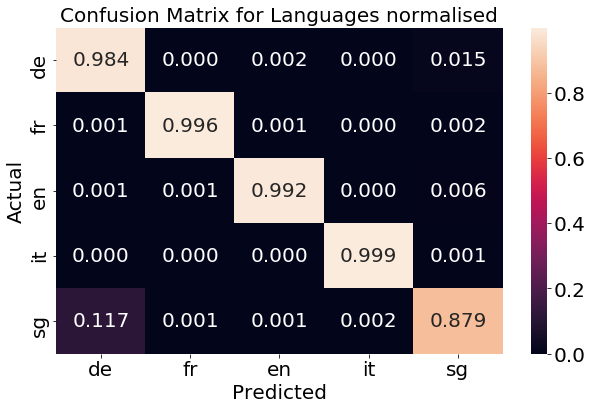

In [88]:
# show the accuracy on the testing set
print("[INFO] evaluating on testing set...")
(loss, accuracy) = model3.evaluate(vectorizer3.transform(X_test), y_test, batch_size=128, verbose=1)
print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss, accuracy * 100))

print("\n\nTesting recall on SMS:\n")
sms_predicted = model3.predict(vectorizer3.transform(sms_sg)).argmax(axis=1)
eval_recall_sms(sms_predicted)

print("\n\nValidate using the leipzig validation set:\n")
valid_predicted = model3.predict(vectorizer3.transform(X_valid)).argmax(axis=1)
print_results(y_valid, valid_predicted)
plot_confusion_matrix(y_valid, valid_predicted, normalised=True)

array([4, 3, 4, ..., 4, 4, 4])